# Audio pattern recognition

In [1]:
import seaborn as sns

from src.utility import show_duration_distribution, plot_history
from src.data_processing import FeatureExtractor
from src.dataset import Dataset

sns.set_theme()
speech_path, song_path, save_path = "data/raw/speech", "data/raw/song", "data/processed"

## Audio duration analysis
Plot of the average speech and song duration. The feature extractor fixes the len to the max len. 

100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


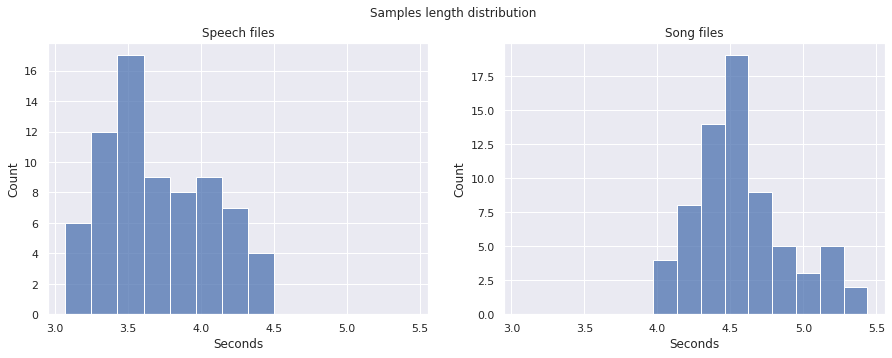

Max len of data samples:  119925


In [2]:
# MAX_LEN = show_duration_distribution(speech_path, song_path, limit_per_actor=3)
# print("Max len of data samples: ", MAX_LEN)

## Preprocessing and feature extraction

The first step of the methodology consists in extracting the first 13 mfcc from the speech and song files.

In [3]:
MAX_LEN = 140526
fe = FeatureExtractor(speech_path=speech_path, 
                      song_path=song_path,
                      save_path=save_path, 
                      verbose=True, 
                      file_per_actor_limit=-1, 
                      audio_fixed_size=MAX_LEN)

data = fe.get_training_data(overwrite=False)

Data found on disk


# SVM, K-NN and NN comparison

After extracting features, the first part of the project consists in comparing the performance of Neural Networks, SVM and K-NN. They are tested on the emotion label.

In [4]:
d = Dataset(data, augment=True)
X_train, X_val, X_test, y_train, y_val, y_test = d.get_training_data("merge", train_perc=0.6, val_perc=0.2)
X_train.shape, X_val.shape, X_test.shape

((2885, 312), (963, 312), (481, 312))

### SVM training

In [5]:
from sklearn.svm import SVC

x, _ = y_train.shape
x2, _ = y_val.shape
reshaped_y_train = y_train.reshape(x)
reshaped_y_val = y_val.reshape(x2)

svm_model = SVC()
svm_model.fit(X_train, reshaped_y_train)
print(f"SVM Accuracy on train: {svm_model.score(X_train, reshaped_y_train)}")
print(f"SVM Accuracy on validation:  {svm_model.score(X_val, reshaped_y_val)}")

SVM Accuracy on train: 0.6894280762564992
SVM Accuracy on validation:  0.5680166147455867


### KNN training
Here K is set to be sqrt of the number of training samples.

In [6]:
from sklearn.neighbors import KNeighborsClassifier as KNN

k = int(len(y_train)**(1/2))
k += int((k%2)==0)

knn_model = KNN(k)
knn_model.fit(X_train, reshaped_y_train)    

print(f"{k}-NN Accuracy on validation: {knn_model.score(X_val, reshaped_y_val)}")

53-NN Accuracy on validation: 0.43613707165109034


### Neural network training


In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.regularizers import L1, L2, L1L2

from matplotlib import pyplot as plt

nn_model = Sequential()
nn_model.add(Input(shape=X_train[0].shape))
nn_model.add(Dense(150, activation="relu", kernel_regularizer=L1L2(l1=1e-5, l2=1e-4), bias_regularizer=L2(1e-4), activity_regularizer=L2(1e-5)))
nn_model.add(Dropout(0.5))  # <-- and here
nn_model.add(Dense(75, activation="relu", kernel_regularizer=L1L2(l1=1e-5, l2=1e-4), bias_regularizer=L2(1e-4), activity_regularizer=L2(1e-5)))
nn_model.add(Dropout(0.5))  # <-- and here
nn_model.add(Dense(8, activation="softmax"))
nn_model.compile(optimizer='sgd', loss=SparseCategoricalCrossentropy(), metrics=["accuracy"])

NameError: name 'X_train' is not defined

In [18]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath="data/models/nn.hdf5",
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

history = nn_model.fit(X_train, y_train, validation_data=(X_val, y_val), 
                       epochs=300, verbose=1, callbacks=[model_checkpoint_callback])

nn_model.load_weights("data/models/nn.hdf5")

Epoch 1/300
91/91 [==============================] - 0s 4ms/step - loss: 0.8939 - accuracy: 0.6950 - val_loss: 1.1138 - val_accuracy: 0.6428
Epoch 2/300
91/91 [==============================] - 0s 4ms/step - loss: 0.8762 - accuracy: 0.6946 - val_loss: 1.1236 - val_accuracy: 0.6251
Epoch 3/300
91/91 [==============================] - 0s 4ms/step - loss: 0.8938 - accuracy: 0.6891 - val_loss: 1.1187 - val_accuracy: 0.6376
Epoch 4/300
91/91 [==============================] - 0s 4ms/step - loss: 0.8793 - accuracy: 0.6977 - val_loss: 1.1645 - val_accuracy: 0.6116
Epoch 5/300
91/91 [==============================] - 0s 3ms/step - loss: 0.9081 - accuracy: 0.6901 - val_loss: 1.1275 - val_accuracy: 0.6428
Epoch 6/300
91/91 [==============================] - 0s 4ms/step - loss: 0.8943 - accuracy: 0.6964 - val_loss: 1.1322 - val_accuracy: 0.6293
Epoch 7/300
91/91 [==============================] - 0s 3ms/step - loss: 0.8818 - accuracy: 0.6898 - val_loss: 1.1151 - val_accuracy: 0.6303
Epoch 8/300
9

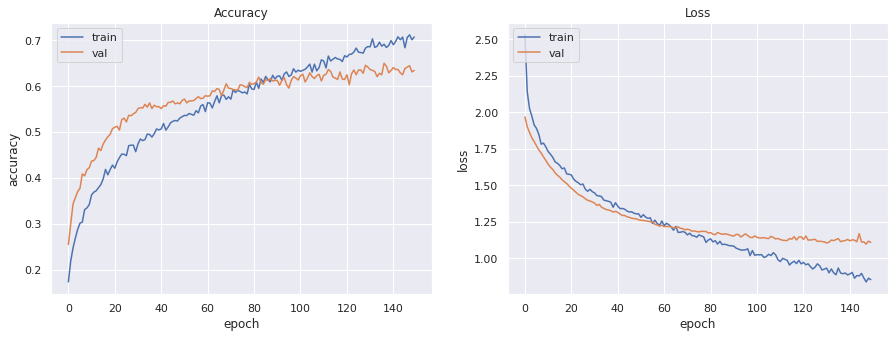

In [16]:
plot_history(history)

In [17]:
nn_model.evaluate(X_test, y_test)

16/16 [==============================] - 0s 2ms/step - loss: 0.9654 - accuracy: 0.6902


[0.9654119610786438, 0.6902287006378174]